In [28]:
### Main
import time
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from scipy.sparse.linalg import svds

### sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.extmath import randomized_svd
from sklearn.model_selection import train_test_split

### Custom
from src.data import *
from src.utils import *
from src.main import *

In [2]:
cfg = {
    "beta":0.001,
    "gamma":0.001,
    "n_clusters":50,
    "n_models":2,
    "verbose":True,
    "train_size": 0.01,
    "weak_size": 0.1,
    "test_size": 0.89,
    "random_state":42,
    "path":"./data/pp_gas_emission/",
    "y":["CO", "NOX"],
    "rank":100,
}

np.random.seed(42)

### Data Extraction

In [3]:
data_2015 = pd.read_csv(cfg["path"]+"gt_2015.csv")
X_data_2015 = data_2015.drop(cfg["y"], axis=1).to_numpy()
y_data_2015 = data_2015[cfg["y"]].to_numpy()

In [4]:
size_weak = cfg["weak_size"]/(cfg["train_size"] + cfg["weak_size"])
X_train, X_test, y_train, y_test = train_test_split(X_data_2015, y_data_2015,
                                                    test_size=cfg["test_size"], random_state=cfg["random_state"])
X_train, X_weak, y_train, y_weak = train_test_split(X_train, y_train,
                                                    test_size=size_weak, random_state=cfg["random_state"])

X_all = np.concatenate([X_train, X_weak, X_test])
y_all = np.concatenate([y_train, y_weak, y_test])

In [5]:
ScaleX = MinMaxScaler()
X_all_scaled = ScaleX.fit_transform(X_all)
W = get_W_k_means(X_all_scaled, 
                  n_clusters=cfg["n_clusters"],
                  n_models=cfg["n_models"],
                  verbose=cfg["verbose"])

neigh_100 = W.argsort()[:, -100:][:, ::-1]
L = []
for i in (pbar := tqdm(range(neigh_100.shape[0]))):
    #neigh_20 = np.argpartition((y_all[neigh_100[i]]**2).sum(axis=1), 20)[:20]
    cov = np.cov(y_all[neigh_100[i]], rowvar=False)
    try:
        L_i = np.linalg.cholesky(cov)
        L_idx = np.tril_indices_from(L_i)
        L.append(L_i[L_idx])
    except LinAlgError:
        print("Cholesky Failed")
        break

Fitting 2 KMeans models: 1 2 

  0%|          | 0/7384 [00:00<?, ?it/s]

In [6]:
L_all = np.stack(L)
A_all = y_all

L_train = L_all[:X_train.shape[0]]
A_train = A_all[:X_train.shape[0]]
L_weak = L_all[X_train.shape[0]:X_train.shape[0]+X_weak.shape[0]]
A_weak = A_all[X_train.shape[0]:X_train.shape[0]+X_weak.shape[0]]
L_test = L_all[X_train.shape[0]+X_weak.shape[0]:]
A_test = A_all[X_train.shape[0]+X_weak.shape[0]:]

X_full = np.concatenate([X_train, X_weak, X_test])
Y_full = np.concatenate([y_train, y_weak, np.zeros_like(y_test)])
L_full = np.concatenate([L_train, L_weak, np.zeros_like(L_test)])

B_full = np.diag(np.concatenate([
    np.ones(X_train.shape[0]+X_weak.shape[0])*cfg["beta"] + 1,
    np.ones(X_test.shape[0])*cfg["beta"]]))

### Time Experiments and Accuracy

#### Full Inverse

In [7]:
start_time = time.time()
W = get_W_k_means(X_all_scaled, 
                  n_clusters=cfg["n_clusters"],
                  n_models=cfg["n_models"])

A_star, L_star = solve(W, B_full, Y_full, L_full, gamma=cfg["gamma"])
full_inverse_time = time.time() - start_time

In [9]:
A_star_gt_train = A_star[:X_train.shape[0]]
L_star_gt_train = L_star[:X_train.shape[0]]

A_star_gt_weak = A_star[X_train.shape[0]:X_train.shape[0]+X_weak.shape[0]]
L_star_gt_weak = L_star[X_train.shape[0]:X_train.shape[0]+X_weak.shape[0]]

A_star_gt_test = A_star[X_train.shape[0]+X_weak.shape[0]:]
L_star_gt_test = L_star[X_train.shape[0]+X_weak.shape[0]:]

print("--- %s seconds ---" % full_inverse_time)
get_statistics(A_train, L_train, A_star_gt_train, L_star_gt_train,
               A_weak, L_weak, A_star_gt_weak, L_star_gt_weak,
               A_test, L_test, A_star_gt_test, L_star_gt_test,)

--- 8.539137125015259 seconds ---
L2
Train L2 1.74317
Weak L2 2.51588
Test L2 49.75380

MWD
Train L2 1.93715
Weak L2 2.63578
Test L2 52.47645


#### Nystom Method

In [10]:
start_time = time.time()
nystrom = Nystrom(cfg["rank"])
C_1_N, C_2_N = nystrom(W)
D = np.diag(np.sum(W, axis=1))

A_star, L_star = solve_sparse(D, C_1_N, C_2_N, B_full, Y_full, L_full, gamma=cfg["gamma"])
nystrom_time = time.time() - start_time

In [11]:
A_star_N_train = A_star[:X_train.shape[0]]
L_star_N_train = L_star[:X_train.shape[0]]

A_star_N_weak = A_star[X_train.shape[0]:X_train.shape[0]+X_weak.shape[0]]
L_star_N_weak = L_star[X_train.shape[0]:X_train.shape[0]+X_weak.shape[0]]

A_star_N_test = A_star[X_train.shape[0]+X_weak.shape[0]:]
L_star_N_test = L_star[X_train.shape[0]+X_weak.shape[0]:]

print("--- %s seconds ---" % nystrom_time)
get_statistics(A_train, L_train, A_star_N_train, L_star_N_train,
               A_weak, L_weak, A_star_N_weak, L_star_N_weak,
               A_test, L_test, A_star_N_test, L_star_N_test,)

--- 3.909219980239868 seconds ---
L2
Train L2 11.81876
Weak L2 21.24649
Test L2 592.09134

MWD
Train L2 12.09975
Weak L2 21.53375
Test L2 600.61976


#### Truncated SVD

In [17]:
start_time = time.time()
u, s, vt = svds(W, k=cfg["rank"])
C_1_T_svd, C_2_T_svd = u, np.diag(s)@vt
D = np.diag(np.sum(W, axis=1))

A_star, L_star = solve_sparse(D, C_1_T_svd, C_2_T_svd, B_full, Y_full, L_full, gamma=cfg["gamma"])
truncated_svd_time = time.time() - start_time

In [19]:
A_star_T_train = A_star[:X_train.shape[0]]
L_star_T_train = L_star[:X_train.shape[0]]

A_star_T_weak = A_star[X_train.shape[0]:X_train.shape[0]+X_weak.shape[0]]
L_star_T_weak = L_star[X_train.shape[0]:X_train.shape[0]+X_weak.shape[0]]

A_star_T_test = A_star[X_train.shape[0]+X_weak.shape[0]:]
L_star_T_test = L_star[X_train.shape[0]+X_weak.shape[0]:]

print("--- %s seconds ---" % truncated_svd_time)
get_statistics(A_train, L_train, A_star_T_train, L_star_T_train,
               A_weak, L_weak, A_star_T_weak, L_star_T_weak,
               A_test, L_test, A_star_T_test, L_star_T_test,)

--- 15.31299114227295 seconds ---
L2
Train L2 1.74317
Weak L2 2.51588
Test L2 49.75380

MWD
Train L2 1.93715
Weak L2 2.63578
Test L2 52.47645


#### Random SVD

In [15]:
start_time = time.time()
u, s, vt = randomized_svd(W, n_components=cfg["rank"], random_state=cfg["random_state"])
C_1_R_svd, C_2_R_svd = u, np.diag(s)@vt
D = np.diag(np.sum(W, axis=1))

A_star, L_star = solve_sparse(D, C_1_R_svd, C_2_R_svd, B_full, Y_full, L_full, gamma=cfg["gamma"])
random_svd_time = time.time() - start_time

In [16]:
A_star_R_train = A_star[:X_train.shape[0]]
L_star_R_train = L_star[:X_train.shape[0]]

A_star_R_weak = A_star[X_train.shape[0]:X_train.shape[0]+X_weak.shape[0]]
L_star_R_weak = L_star[X_train.shape[0]:X_train.shape[0]+X_weak.shape[0]]

A_star_R_test = A_star[X_train.shape[0]+X_weak.shape[0]:]
L_star_R_test = L_star[X_train.shape[0]+X_weak.shape[0]:]

print("--- %s seconds ---" % random_svd_time)
get_statistics(A_train, L_train, A_star_R_train, L_star_R_train,
               A_weak, L_weak, A_star_R_weak, L_star_R_weak,
               A_test, L_test, A_star_R_test, L_star_R_test,)

--- 5.171774387359619 seconds ---
L2
Train L2 1.74317
Weak L2 2.51588
Test L2 49.75380

MWD
Train L2 1.93715
Weak L2 2.63578
Test L2 52.47645


### Rank experiments

*For all methods*
- Execusion time
- Divergence from original solution
- Fro norm of W approximation

In [36]:
results = {
    "Time":{
        "Nystrom Decomposition":[],
        "Truncated SVD":[],
        "Randomized SVD":[],
    },
    "Accuracy":{
        "Nystrom Decomposition":{
            "Train":[],
            "Test":[],
            "Weak":[],
        },
        "Truncated SVD":{
            "Train":[],
            "Test":[],
            "Weak":[],
        },
        "Randomized SVD":{
            "Train":[],
            "Test":[],
            "Weak":[],
        }
    },
    "Distance to W":{
        "Nystrom Decomposition":[],
        "Truncated SVD":[],
        "Randomized SVD":[],
    }
}

for r in tqdm(range(50, 1000, 50)):
    ### Nystrom
    start_time = time.time()
    nystrom = Nystrom(r)
    C_1_N, C_2_N = nystrom(W)
    A_star, L_star = solve_sparse(D, C_1_N, C_2_N, B_full, Y_full, L_full, gamma=cfg["gamma"])
    nystrom_time = time.time() - start_time

    A_star_N_train = A_star[:X_train.shape[0]]
    L_star_N_train = L_star[:X_train.shape[0]]

    A_star_N_weak = A_star[X_train.shape[0]:X_train.shape[0]+X_weak.shape[0]]
    L_star_N_weak = L_star[X_train.shape[0]:X_train.shape[0]+X_weak.shape[0]]

    A_star_N_test = A_star[X_train.shape[0]+X_weak.shape[0]:]
    L_star_N_test = L_star[X_train.shape[0]+X_weak.shape[0]:]

    results["Time"]["Nystrom Decomposition"].append(nystrom_time)
    results["Accuracy"]["Nystrom Decomposition"]["Train"].append(get_Wasserstain(A_train, L_train, A_star_N_train, L_star_N_train))
    results["Accuracy"]["Nystrom Decomposition"]["Weak"].append(get_Wasserstain(A_weak, L_weak, A_star_N_weak, L_star_N_weak))
    results["Accuracy"]["Nystrom Decomposition"]["Test"].append(get_Wasserstain(A_test, L_test, A_star_N_test, L_star_N_test))
    results["Distance to W"]["Nystrom Decomposition"].append(np.linalg.norm(W - C_1_N@C_2_N))

    ### Truncated SVD
    start_time = time.time()
    u, s, vt = svds(W, k=r)
    C_1_T_svd, C_2_T_svd = u, np.diag(s)@vt
    A_star, L_star = solve_sparse(D, C_1_T_svd, C_2_T_svd, B_full, Y_full, L_full, gamma=cfg["gamma"])
    truncated_svd_time = time.time() - start_time

    A_star_T_train = A_star[:X_train.shape[0]]
    L_star_T_train = L_star[:X_train.shape[0]]

    A_star_T_weak = A_star[X_train.shape[0]:X_train.shape[0]+X_weak.shape[0]]
    L_star_T_weak = L_star[X_train.shape[0]:X_train.shape[0]+X_weak.shape[0]]

    A_star_T_test = A_star[X_train.shape[0]+X_weak.shape[0]:]
    L_star_T_test = L_star[X_train.shape[0]+X_weak.shape[0]:]

    results["Time"]["Truncated SVD"].append(truncated_svd_time)
    results["Accuracy"]["Truncated SVD"]["Train"].append(get_Wasserstain(A_train, L_train, A_star_T_train, L_star_T_train))
    results["Accuracy"]["Truncated SVD"]["Weak"].append(get_Wasserstain(A_weak, L_weak, A_star_T_weak, L_star_T_weak))
    results["Accuracy"]["Truncated SVD"]["Test"].append(get_Wasserstain(A_test, L_test, A_star_T_test, L_star_T_test))
    results["Distance to W"]["Truncated SVD"].append(np.linalg.norm(W - C_1_T_svd@C_2_T_svd))

    ### Random SVD
    start_time = time.time()
    u, s, vt = randomized_svd(W, n_components=r, random_state=cfg["random_state"])
    C_1_R_svd, C_2_R_svd = u, np.diag(s)@vt
    A_star, L_star = solve_sparse(D, C_1_R_svd, C_2_R_svd, B_full, Y_full, L_full, gamma=cfg["gamma"])
    random_svd_time = time.time() - start_time

    A_star_R_train = A_star[:X_train.shape[0]]
    L_star_R_train = L_star[:X_train.shape[0]]

    A_star_R_weak = A_star[X_train.shape[0]:X_train.shape[0]+X_weak.shape[0]]
    L_star_R_weak = L_star[X_train.shape[0]:X_train.shape[0]+X_weak.shape[0]]

    A_star_R_test = A_star[X_train.shape[0]+X_weak.shape[0]:]
    L_star_R_test = L_star[X_train.shape[0]+X_weak.shape[0]:]

    results["Time"]["Randomized SVD"].append(random_svd_time)
    results["Accuracy"]["Randomized SVD"]["Train"].append(get_Wasserstain(A_train, L_train, A_star_R_train, L_star_R_train))
    results["Accuracy"]["Randomized SVD"]["Weak"].append(get_Wasserstain(A_weak, L_weak, A_star_R_weak, L_star_R_weak))
    results["Accuracy"]["Randomized SVD"]["Test"].append(get_Wasserstain(A_test, L_test, A_star_R_test, L_star_R_test))
    results["Distance to W"]["Randomized SVD"].append(np.linalg.norm(W - C_1_R_svd@C_2_R_svd))


  0%|          | 0/19 [00:00<?, ?it/s]

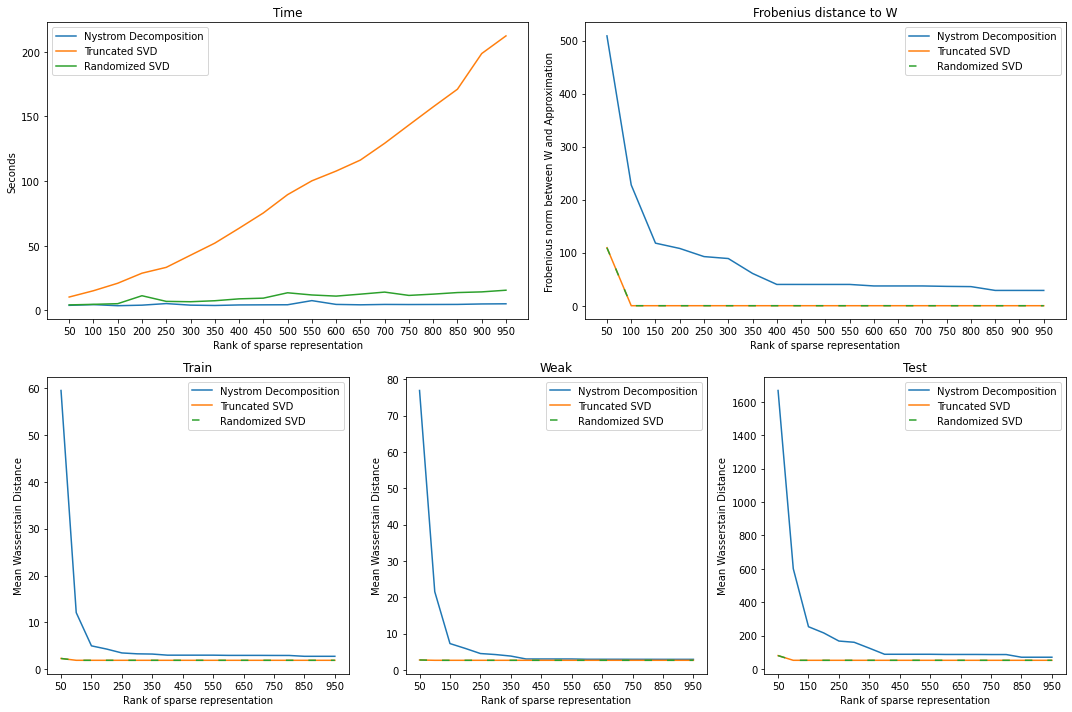

In [56]:
xticks = list(range(50, 1000, 50))
fig, axs = plt.subplots(ncols=6, nrows=2, figsize=(15, 10))
gs = axs[0, 0].get_gridspec()
for ax in axs.flatten():
    ax.remove()

ax00 = fig.add_subplot(gs[0, 0:3])
ax00.set_title("Time")
for key, item in results["Time"].items():
    ax00.plot(xticks, item, label=key)
ax00.legend()
ax00.set_ylabel("Seconds")
ax00.set_xlabel("Rank of sparse representation")
ax00.set_xticks(xticks)

ax01 = fig.add_subplot(gs[0, 3:])
ax01.set_title("Frobenius distance to W")
for key, item in results["Distance to W"].items():
    linestyle = (0, (5, 10)) if key == "Randomized SVD" else None
    ax01.plot(xticks, item, label=key, linestyle=linestyle)
ax01.legend()
ax01.set_ylabel("Frobenious norm between W and Approximation")
ax01.set_xlabel("Rank of sparse representation")
ax01.set_xticks(xticks)

ax11 = fig.add_subplot(gs[1, 0:2])
ax11.set_title("Train")
ax11.set_ylabel("Mean Wasserstain Distance")
ax11.set_xlabel("Rank of sparse representation")

ax12 = fig.add_subplot(gs[1, 2:4])
ax12.set_title("Weak")
ax12.set_ylabel("Mean Wasserstain Distance")
ax12.set_xlabel("Rank of sparse representation")

ax13 = fig.add_subplot(gs[1, 4:6])
ax13.set_title("Test")
ax13.set_ylabel("Mean Wasserstain Distance")
ax13.set_xlabel("Rank of sparse representation")

for key, item in results["Accuracy"].items():
    linestyle = (0, (5, 10)) if key == "Randomized SVD" else None
    ax11.plot(xticks, item["Train"], label=key, linestyle=linestyle)
    ax12.plot(xticks, item["Weak"], label=key, linestyle=linestyle)
    ax13.plot(xticks, item["Test"], label=key, linestyle=linestyle)
    
ax11.set_xticks(xticks[::2])
ax12.set_xticks(xticks[::2])
ax13.set_xticks(xticks[::2])

ax11.legend()
ax12.legend()
ax13.legend()

fig.tight_layout()

plt.show()